### To do 
#### Explanations
* Add an image of the Black Jack Game
* Explain the results of the value table

In [15]:
import gym
import numpy as np

In [16]:
env=gym.make('Blackjack-v0')

[2019-08-31 13:11:23,636] Making new env: Blackjack-v0


 Blackjack is a card game where the goal is to obtain cards that sum to as
 near as possible to 21 without going over.  
 They're playing against a fixed dealer.
 Face cards (Jack, Queen, King) have point value 10.
 Aces can either count as 11 or 1, and it's called 'usable' at 11.  
 
This game is placed with an infinite deck (or with replacement). 
The game starts with each (player and dealer) having one face up and one face down card.
The player can request additional cards (hit=1) until they decide to stop(stick=0) or exceed 21 (bust).
 After the player sticks, the dealer reveals their facedown card, and draws until their sum is 17 or greater.  If the dealer goes bust the player wins.
If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1.

## <a id="mc"></a>Reminder: Monte-Carlo evaluation

Monte Carlo methods are intuitive, episode-based methods. 

The **online Monte-Carlo** algorithm does the following: start from $s$, run the policy until termination (or for a long number of steps) then update the value of all encountered states before restarting an episode. 

Let $(s_0, r_0, s_1, \ldots, s_T)$ be the sequence of transitions of such an episode. Then, this procedure provides an estimate $G_t$ of the value of the state $s_t$ encountered at time step $t$:
<div class="alert-success">**Monte Carlo return:**
$$G_t = \sum_{i>t} \gamma^{i-t} r_i$$
</div>

Let $G^\pi(s)$ be the random variable corresponding to the sum of discounted rewards one can obtain from $s$. Then $V^\pi(s) = \mathbb{E}(G^\pi(s))$. Since $G(s_t)$ is a realization of $R(s)$, one can design a **stochastic approximation** procedure that converges to $G^\pi(s_t)$:
<div class="alert-success">**Stochastic approximation of $V^\pi$:**
$$V(s_t) \leftarrow V(s_t) + \alpha \left[ R_t - V(s_t) \right]$$
</div>

For those unfamiliar with stochastic approximation procedures, we can understand the previous update as: $R_t$ are samples estimates of $V^\pi(s_t)$. If I already have an estimation of $V(s_t)$ of $V^\pi(s_t)$ and I receive a new sample $R_t$, I should "pull" my previous estimate towards $G_t$, but $R_t$ carries a part of noise, so I should be cautious and only take a small step $\alpha$ in the direction of $G_t$. This type of stochastic approximation procedure converges if it respects Robbins-Monro's conditions:
<div class="alert-success">**Robbins-Monro convergence conditions:**
$$\sum\limits_{t=0}^\infty \alpha_t = \infty \quad \textrm{  and  } \quad \sum\limits_{t=0}^\infty \alpha_t^2 < \infty.$$
</div>
Intuitive explanation. These conditions simply say that any value $V^\pi(s)$ should be reachable given any initial guess $V(s)$, no matter how far from $V^\pi(s)$ is from this first guess; hence the $\sum\limits_{t=0}^\infty \alpha_t = \infty$. However, we still need the step-size to be decreasing so that we don't start oscillating around $V^\pi(s)$ when we get closer; so to insure convergence we impose $\sum\limits_{t=0}^\infty \alpha_t^2 < \infty$.

### action space: 2 possible actions
0: stick (stop)
1: hit (draw a new card)

In [17]:
print(env.action_space.n)

2


### observation space
The observation of a 3-tuple of: the players current sum, the dealer's one showing card (1-10 where 1 is ace),
and whether or not the player holds a usable ace (0 or 1)

In [18]:
print(env.observation_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))


### rewards
If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  
The reward for winning is +1, drawing is 0, and losing is -1.

### policy to evaluate

In [19]:
def sample_policy(observation):
    score, dealer_score, usable_ace=observation
    return 0 if score>=20 else 1

### Function to generate an episode following a policy

In [20]:
def generate_episode(policy, env):
    states, actions, rewards=[],[],[]
    
    # initialize the first state
    observation=env.reset()
    
    while True:
        states.append(observation)
        
        # now we select the action using the sample policy function 
        action=sample_policy(observation)
        actions.append(action)
        
        # We perform the action and move to the next state
        observation, reward, done, _=env.step(action)
        rewards.append(reward)
        
        if done:
            break
            
    return states, actions, rewards

### MC prediction algorithm

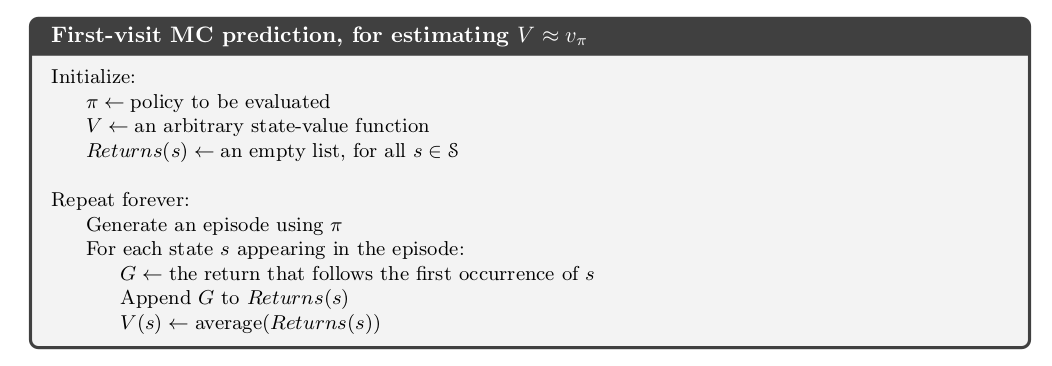

In [21]:
from collections import defaultdict

In [23]:
def first_visit_MC_prediction(policy, env, n_episodes):
    # value_table and state counter initialization
    value_table=defaultdict(float)
    N=defaultdict(int)

    for i in range(n_episodes):
        # generating episodes
        states,actions,rewards=generate_episode(policy, env)
        returns=0
    
        # for each step, we store the rewards to a variable R and the states to a variable S
        # and we calculate returns as the sum of the rewards
        for t in range(len(states)-1,1,-1):
            R=rewards[t]
            S=states[t]
            returns+=R
            
            # check if the state is visited for the first time, if so N(s) and is incremented
            if S not in states[:t]:
                N[S]+=1
                value_table[S]+=(returns-value_table[S])/ N[S]
                
    return value_table

In [24]:
value_table=first_visit_MC_prediction(sample_policy, env, n_episodes=100000)

In [25]:
value_table

defaultdict(float,
            {(8, 4, False): -1.0,
             (8, 6, False): -1.0,
             (9, 1, False): -1.0,
             (9, 2, False): -1.0,
             (9, 6, False): -1.0,
             (9, 7, False): 1.0,
             (9, 10, False): -1.0,
             (10, 1, False): -1.0,
             (10, 2, False): -1.0,
             (10, 3, False): -0.3333333333333333,
             (10, 4, False): -1.0,
             (10, 5, False): 0.6666666666666666,
             (10, 6, False): 0.0,
             (10, 7, False): -0.3333333333333333,
             (10, 8, False): -0.5,
             (10, 9, False): -0.3333333333333333,
             (10, 10, False): -0.6363636363636365,
             (11, 1, False): 0.11111111111111113,
             (11, 2, False): -1.0,
             (11, 3, False): 0.3333333333333333,
             (11, 4, False): -1.0,
             (11, 5, False): 0.12499999999999997,
             (11, 6, False): 0.3333333333333333,
             (11, 7, False): 1.0,
             (11,